In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.init as init
import torch.nn.functional as F

# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### Data

In [2]:
# Load CFashionMNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

trainset = torchvision.datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=1024, num_workers=10, shuffle=True, drop_last=True)

testset = torchvision.datasets.CIFAR10(root='data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1024, num_workers=10, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


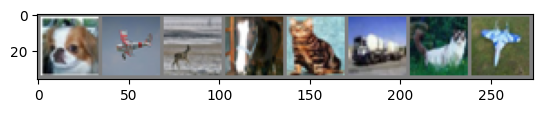

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Function to display the images
def imshow(img):
    img = img*0.5 + 0.5
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

for i, (images, labels) in enumerate(trainloader, 0):
    # Plot some images
    imshow(torchvision.utils.make_grid(images[:8]))  # Display 8 images from the batch
    break

#### Model

In [4]:
from torchsummary import summary

class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            self.relu,
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            self.relu,
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            self.relu,
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            self.relu,
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            self.relu,
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            self.relu,
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            self.relu,
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            self.relu,
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            self.relu,
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            self.relu,
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            self.relu,
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            self.relu,
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            self.relu,
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 1 * 1, 128),
            self.relu,
            nn.Linear(128, 128),
            self.relu,
            nn.Linear(128, 10)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = VGG16()
model = model.to(device)

# Print model
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
              ReLU-3           [-1, 64, 32, 32]               0
              ReLU-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,928
              ReLU-6           [-1, 64, 32, 32]               0
              ReLU-7           [-1, 64, 32, 32]               0
              ReLU-8           [-1, 64, 32, 32]               0
         MaxPool2d-9           [-1, 64, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]          73,856
             ReLU-11          [-1, 128, 16, 16]               0
             ReLU-12          [-1, 128, 16, 16]               0
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 128,

#### Loss, Optimizer, and Evaluation Function

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [6]:
# Function to compute loss and accuracy for test set
def evaluate(model, testloader, criterion):
    model.eval()
    test_loss = 0.0
    running_correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

    accuracy = 100 * running_correct / total
    test_loss = test_loss / len(testloader)
    return test_loss, accuracy

#### Train

In [7]:
# some parameter
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
max_epoch = 150

In [8]:
# train
for epoch in range(max_epoch):
    model.train()
    running_loss = 0.0
    running_correct = 0   # to track number of correct predictions
    total = 0             # to track total number of samples

    for i, (inputs, labels) in enumerate(trainloader, 0):
        # Move inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # Determine class predictions and track accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()        

    epoch_accuracy = 100 * running_correct / total
    epoch_loss = running_loss / (i + 1)
    
    test_loss, test_accuracy = evaluate(model, testloader, criterion)
    print(f"Epoch [{epoch + 1}/{max_epoch}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    
    # save for plot
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch [1/150], Loss: 2.2698, Accuracy: 11.66%, Test Loss: 2.1807, Test Accuracy: 15.13%
Epoch [2/150], Loss: 2.1297, Accuracy: 16.34%, Test Loss: 1.9905, Test Accuracy: 20.22%
Epoch [3/150], Loss: 1.9167, Accuracy: 22.48%, Test Loss: 1.8587, Test Accuracy: 24.37%
Epoch [4/150], Loss: 1.8445, Accuracy: 24.86%, Test Loss: 1.8278, Test Accuracy: 26.56%
Epoch [5/150], Loss: 1.7959, Accuracy: 28.08%, Test Loss: 1.7805, Test Accuracy: 29.52%
Epoch [6/150], Loss: 1.7393, Accuracy: 31.34%, Test Loss: 1.6920, Test Accuracy: 33.31%
Epoch [7/150], Loss: 1.6589, Accuracy: 35.33%, Test Loss: 1.6525, Test Accuracy: 35.86%
Epoch [8/150], Loss: 1.5890, Accuracy: 38.31%, Test Loss: 1.5586, Test Accuracy: 39.83%
Epoch [9/150], Loss: 1.5442, Accuracy: 40.35%, Test Loss: 1.5156, Test Accuracy: 41.65%
Epoch [10/150], Loss: 1.5066, Accuracy: 42.50%, Test Loss: 1.4928, Test Accuracy: 42.10%
Epoch [11/150], Loss: 1.4563, Accuracy: 44.41%, Test Loss: 1.4218, Test Accuracy: 45.59%
Epoch [12/150], Loss: 1.4251, 

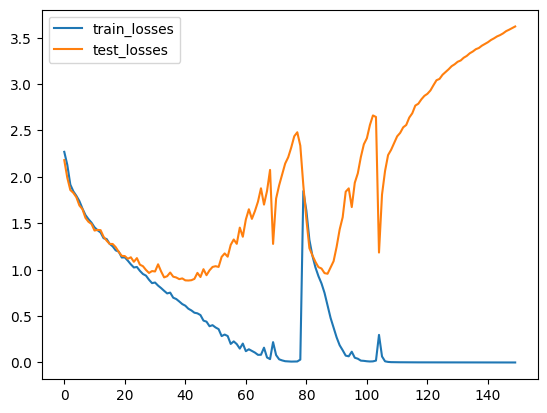

In [9]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label='test_losses')
plt.legend()

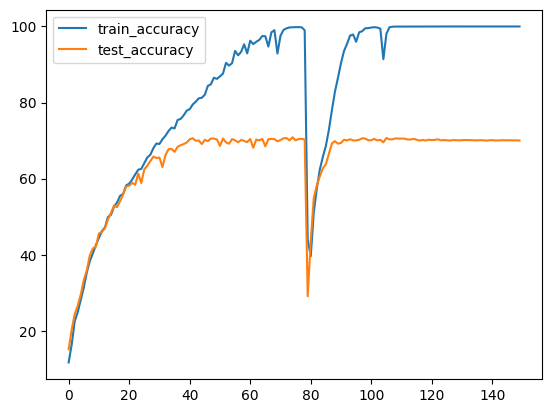

In [10]:
import matplotlib.pyplot as plt

plt.plot(train_accuracies, label='train_accuracy')
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()

In [11]:
import matplotlib.pyplot as plt
%matplotlib qt

plt.plot(train_losses, label='train_losses')
plt.plot(test_losses, label='test_losses')
plt.legend()

In [12]:
import matplotlib.pyplot as plt
%matplotlib qt

plt.plot(train_accuracies, label='train_accuracy')
plt.plot(test_accuracies, label='test_accuracy')
plt.legend()